In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import polyphase
import matplotlib.pyplot as plt
%matplotlib notebook

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from matplotlib import colors

In [3]:
M = np.ones(4) 
chi = 3.10*np.ones(int(0.5*4*(4-1)))
# M = [5,5,1,1] 
# chi = [1,0.5,0.5,0.5,0.5,1]

f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,20,4)
engine.compute()

Computation took 0.76s


<IPython.core.display.Javascript object>


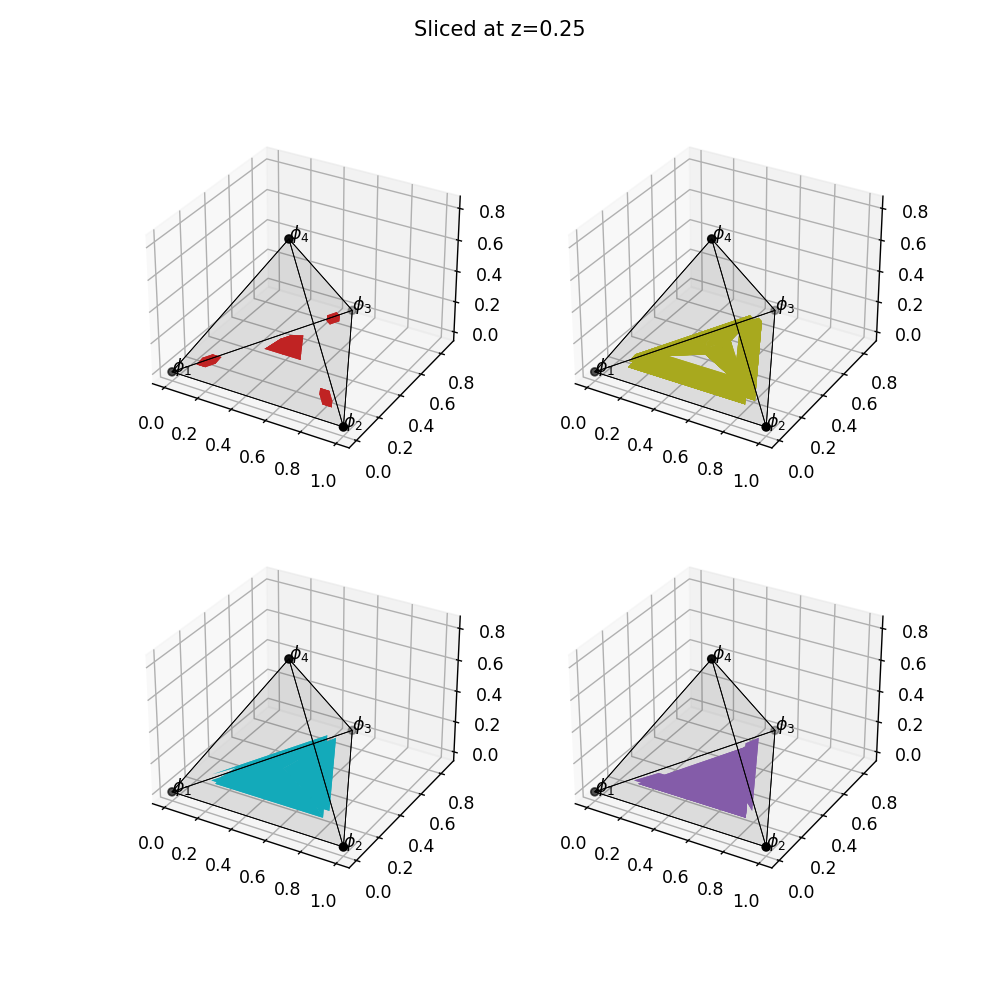

In [4]:
qtplot = polyphase.QuaternaryPlot(engine)
for t in [0.25,1.0]:
    [fig, axs, cbar] = qtplot.plot_simplices(sliceat=t)
    fig.suptitle('Sliced at z={:.2f}'.format(t))
    plt.show()
    break

<IPython.core.display.Javascript object>


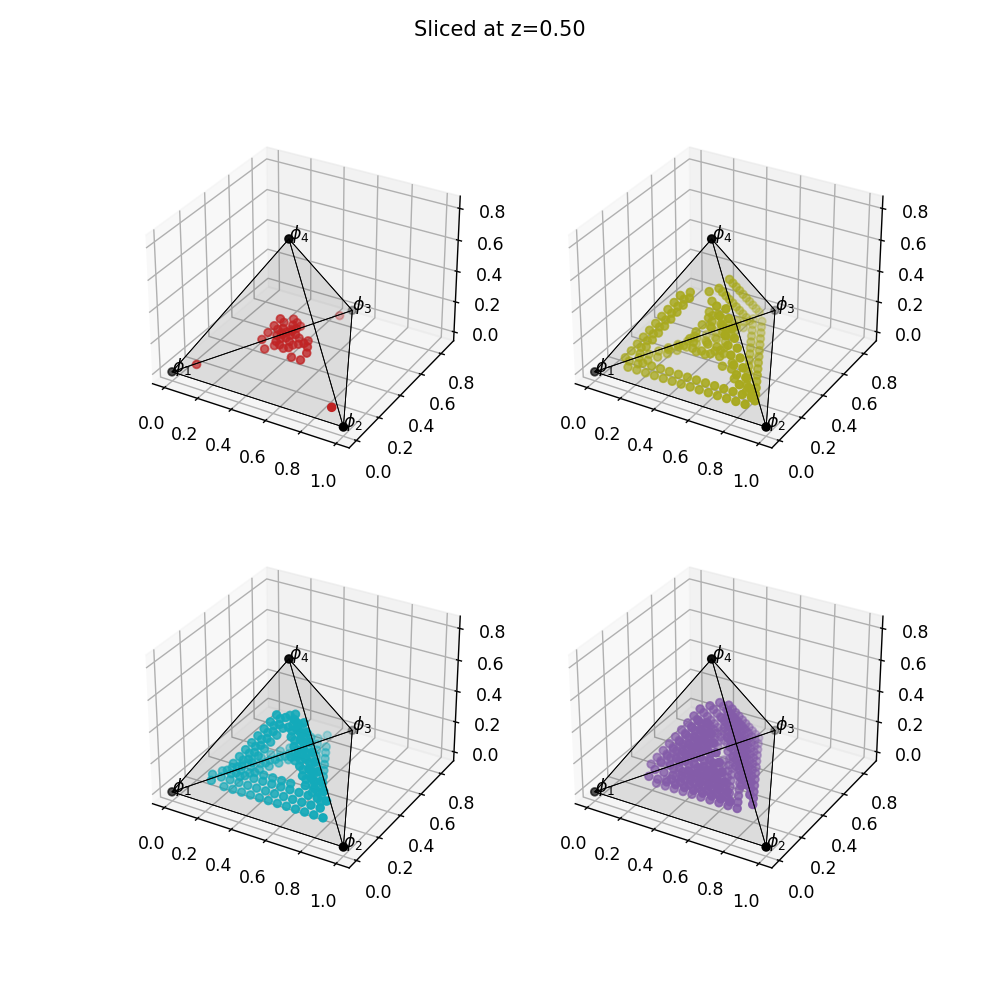

In [5]:
qtplot = polyphase.QuaternaryPlot(engine)
t = 0.5
[fig, axs, cbar] = qtplot.plot_points(sliceat=t)
fig.suptitle('Sliced at z={:.2f}'.format(t))
plt.show()